<a href="https://colab.research.google.com/github/devhemza/BERTweet_sentiment_analysis/blob/main/BERTweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Model


In [1]:
!cd "/content/drive/MyDrive/TER BERTTweet"

In [ ]:
CUDA_LAUNCH_BLOCKING="1"

In [ ]:
"""
!git clone https://github.com/huggingface/transformers.git
%cd transformers/
!pip3 install --upgrade .
"""

'\n!git clone https://github.com/huggingface/transformers.git\n%cd transformers/\n!pip3 install --upgrade .\n'

In [ ]:
!pip3 install emoji
!pip install transformers sentencepiece

In [ ]:
def writeResultsInFile(accuracy, f1_score, random_seed):
    f = open("log", "a")
    f.write(f'Random seed : {random_seed}, accuracy : {accuracy}, f1-score : {f1_score}')
    f.close()


In [ ]:
#imports hugging face 
from transformers import AutoModel, AutoTokenizer 

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization = True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
#imports hugging face 
from transformers import AutoModel, AutoTokenizer 

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization = True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
import transformers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class SATweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation= True,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = SATweetDataset(
        tweets=df.body.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [ ]:
PRE_TRAINED_MODEL_NAME = "vinai/bertweet-base"

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = bertweet.from_pretrained(PRE_TRAINED_MODEL_NAME)
    #self.drop = nn.Dropout(p = 0.33)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    #output = self.drop(pooled_output)
    output = pooled_output
    return self.out(output)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer,  device, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweets_content = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      _, preds = torch.max(outputs, dim=1)
      
      probs = nn.functional.softmax(outputs, dim=1)

      tweets_content.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweets_content, predictions, prediction_probs, real_values

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [ ]:
def avg_rec(y_test, y_pred):
    rec_n, rec_u, rec_p = recall_score(y_test, y_pred, average=None)
    return (1/3) * (rec_n+ rec_u+ rec_p)


In [ ]:
def f1_np(y_test, y_pred):
    f1_n, _,f1_p = f1_score(y_test, y_pred, average=None)
    return 0.5*(f1_n+f1_p)

####SemEval-2018Task3A

In [ ]:
%cd '/content/drive/MyDrive/TER BERTTweet/SemEval-2018Task3A/datasets'

/content/drive/MyDrive/TER BERTTweet/SemEval-2018Task3A/datasets


In [ ]:
df_semEval18_train = pd.read_csv('train/SemEval2018-T3-train-taskA_emoji.txt', skiprows=[0], names = ['id', 'target', 'body'], sep = "\t")
df_semEval18_test = pd.read_csv('goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt', skiprows=[0], names = ['id', 'target', 'body'], sep = "\t")
df_semEval18_train

,id,target,body
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
3812,3830,0,@banditelli regarding what the PSU president does
3813,3831,0,@banditelli But still bothers me that I see no...
3814,3832,0,well now that i've listened to all of into the...
3815,3833,0,Hummingbirds #Are #Experts #at #Hovering #Aft...


In [ ]:
df_semEval18_train['target'] = df_semEval18_train['target'].astype(int)

In [ ]:
df_semEval18_test['target'] = df_semEval18_test['target'].astype(int)

In [ ]:
token_lens = []
for txt in df_semEval18_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


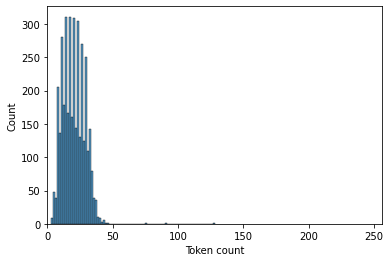

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = max(token_lens)
BATCH_SIZE = 32

In [ ]:
MAX_LEN

128

In [ ]:
RANDOM_SEED = 1993
df_train, df_val = train_test_split(df_semEval18_train, test_size=0.1, random_state=RANDOM_SEED)
df_test = df_semEval18_test

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['ironic', 'non-ironic']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS
"""
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
"""
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'bertweet_best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.5940788655921265 accuracy 0.6791848617176128
Val   loss 0.5300394569834074 accuracy 0.7094240837696335

Epoch 2/30
----------
Train loss 0.43993785480658215 accuracy 0.8
Val   loss 0.5181503320733706 accuracy 0.7486910994764399

Epoch 3/30
----------
Train loss 0.34728238535010153 accuracy 0.8585152838427949
Val   loss 0.5567613293727239 accuracy 0.7539267015706806

Epoch 4/30
----------
Train loss 0.2503064120947211 accuracy 0.9053857350800583
Val   loss 0.6340859457850456 accuracy 0.7513089005235603

Epoch 5/30
----------
Train loss 0.18359483312815428 accuracy 0.937991266375546
Val   loss 0.7783646633227667 accuracy 0.7329842931937173

Epoch 6/30
----------
Train loss 0.1363497181036682 accuracy 0.95254730713246
Val   loss 0.7492217198014259 accuracy 0.7591623036649215

Epoch 7/30
----------
Train loss 0.11004832167937248 accuracy 0.9688500727802039
Val   loss 0.8249887997905413 accuracy 0.7643979057591623

Epoch 8/30
----------
Train loss 0.093246

In [ ]:
model.load_state_dict(torch.load('bertweet_best_model_state.bin'))

<All keys matched successfully>

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8239795918367346

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      ironic       0.97      0.73      0.83       473
  non-ironic       0.70      0.96      0.81       311

    accuracy                           0.82       784
   macro avg       0.84      0.85      0.82       784
weighted avg       0.86      0.82      0.83       784



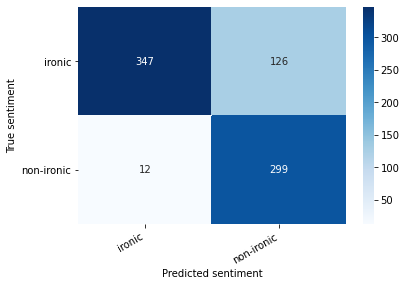

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.8239795918367347

In [ ]:
_,f1_p = f1_score(y_test, y_pred, average=None)

In [ ]:
print(f1_p)

0.8125


###SemEval 2019 TASK 5

In [ ]:
%cd '/content/drive/MyDrive/TER BERTTweet/SemEval2019Task5/datasets'

/content/drive/MyDrive/TER BERTTweet/SemEval2019Task5/datasets


In [ ]:
!ls


best_model_state.bin	 hateval2019_en_train.csv  hateval2019_es_train.csv
hateval2019_en_dev.csv	 hateval2019_es_dev.csv
hateval2019_en_test.csv  hateval2019_es_test.csv


In [ ]:
df_semEval19_train = pd.read_csv('hateval2019_en_train.csv', sep = ",")
#df_semEval19_train_val = pd.read_csv('hateval2019_en_dev.csv', sep = "\t")
df_semEval19_valid = pd.read_csv('hateval2019_en_dev.csv',  sep = ",")
df_test_gold = pd.read_csv('hateval2019_en_test.csv', sep = ",")
#df_result = pd.read_csv('en_a.tsv', sep = "\t", names=["id", "target"])
#df_test_gold = pd.concat([df_semEval19_test, df_result.target], axis=1)

In [ ]:
df_test_gold

,id,text,HS,TR,AG
0,34243,"@local1025 @njdotcom @GovMurphy Oh, I could ha...",0,0,0
1,30593,Several of the wild fires in #california and #...,0,0,0
2,31427,@JudicialWatch My question is how do you reset...,0,0,0
3,31694,"#Europe, you've got a problem! We must hurry...",1,0,0
4,31865,This is outrageous! #StopIllegalImmigration #...,1,0,0
...,...,...,...,...,...
2995,31368,you can never take a L off a real bitch😩 im ho...,1,1,0
2996,30104,@Brian_202 likes to call me a cunt & a bitch b...,1,1,0
2997,31912,@kusha1a @Camio_the_wise @shoe0nhead 1. Never ...,1,1,0
2998,31000,If i see and know you a hoe why would i hit yo...,1,1,0


In [ ]:
df_train = df_semEval19_train.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
#df_train_val = df_semEval19_train_val.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
df_val = df_semEval19_valid.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
df_test = df_test_gold.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})

In [ ]:
df_train

,id,body,target
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0
4,205,Orban in Brussels: European leaders are ignori...,0
...,...,...,...
8995,9196,@mmdwriter @JRubinBlogger @BenSasse I am proud...,0
8996,9197,@CheriJacobus Hollywood is complicit in the ra...,0
8997,9198,@amaziah_filani What a fucking cunt I hate see...,1
8998,9199,Hysterical woman like @CoryBooker,0


In [ ]:
df_train_val = pd.concat([df_train, df_val], axis = 0)
df_train_val

,id,body,target
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0
4,205,Orban in Brussels: European leaders are ignori...,0
...,...,...,...
995,19196,@SamEnvers you unfollowed me? Fuck you pussy,0
996,19197,@DanReynolds STFU BITCH! AND YOU GO MAKE SOME ...,1
997,19198,"@2beornotbeing Honey, as a fellow white chick,...",0
998,19199,I hate bitches who talk about niggaz with kids...,1


In [ ]:
RANDOM_SEED = 16
df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

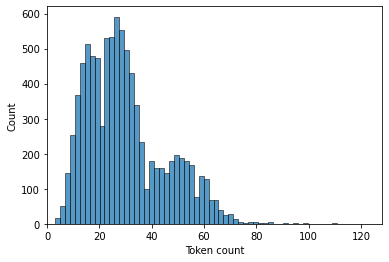

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['hateful', 'non-hateful']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 111])
torch.Size([32, 111])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

404 Client Error: Not Found for url: https://huggingface.co/vinai/bert-base/resolve/main/config.json


OSError: ignored

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.563

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     hateful       0.92      0.27      0.42      1740
 non-hateful       0.49      0.97      0.65      1260

    accuracy                           0.56      3000
   macro avg       0.70      0.62      0.53      3000
weighted avg       0.74      0.56      0.52      3000



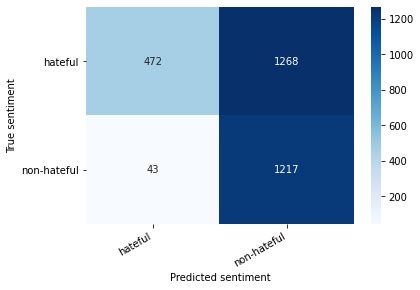

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.563

In [ ]:
f1_score(y_test, y_pred)

0.6499332443257677

In [ ]:
df_test["y_pred"] = y_pred

In [ ]:
df_test.to_csv("bertweet_preds.csv", sep="\t")

##SemEval 2016 Task 6

In [ ]:
%cd "/content/drive/MyDrive/TER BERTTweet/SemEval2016Task6"

/content/drive/MyDrive/TER BERTTweet/SemEval2016Task6


In [ ]:
!ls -l

total 527623
-rw------- 1 root root 539693729 Jan 24 04:19 best_model_state.bin
-rw------- 1 root root        78 Jan 24 04:22 log
-rw------- 1 root root    179446 Jan 19  2016 SemEval2016-Task6-subtaskA-testdata-gold.txt
-rw------- 1 root root    397092 Jan  3 16:50 semeval2016-task6-trainingdata.txt
-rw------- 1 root root     13911 Jan  2 13:51 semeval2016-task6-trialdata.txt


In [ ]:
df_sem16train = pd.read_csv("semeval2016-task6-trainingdata.txt", sep="\t", encoding = "ISO-8859-1")
df_sem16val = pd.read_csv("semeval2016-task6-trialdata.txt", sep="\t", encoding = "ISO-8859-1")
df_sem16test = pd.read_csv("SemEval2016-Task6-subtaskA-testdata-gold.txt", sep="\t", encoding = "ISO-8859-1")

In [ ]:
df_sem16train.Tweet[0]

'dear lord thank u for all of ur blessings forgive my sins lord give me strength and energy for this busy day ahead #blessed #hope #SemST'

In [ ]:
df_sem16train["Stance"].unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

In [ ]:
df_sem16train["Target"].unique()

array(['Atheism', 'Climate Change is a Real Concern', 'Feminist Movement',
       'Hillary Clinton', 'Legalization of Abortion'], dtype=object)

In [ ]:
df_sem16train["Target"] = df_sem16train["Target"].astype('category')
df_sem16train['target'] = df_sem16train['Target'].cat.codes

In [ ]:
df_train = df_sem16train[["Tweet", "Stance"]]
df_val = df_sem16val[["Tweet", "Stance"]]

In [ ]:
df_train = df_val.append(df_train)

In [ ]:
df_train

,Tweet,Stance
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST
1,Hillary is our best choice if we truly want to...,FAVOR
2,@TheView I think our country is ready for a fe...,AGAINST
3,I just gave an unhealthy amount of my hard-ear...,AGAINST
4,@PortiaABoulger Thank you for adding me to you...,NONE
...,...,...
2809,"There's a law protecting unborn eagles, but no...",AGAINST
2810,I am 1 in 3... I have had an abortion #Abortio...,AGAINST
2811,How dare you say my sexual preference is a cho...,AGAINST
2812,"Equal rights for those 'born that way', no rig...",AGAINST


In [ ]:
df_val

,Tweet,Stance
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST
1,Hillary is our best choice if we truly want to...,FAVOR
2,@TheView I think our country is ready for a fe...,AGAINST
3,I just gave an unhealthy amount of my hard-ear...,AGAINST
4,@PortiaABoulger Thank you for adding me to you...,NONE
...,...,...
95,@Corey_Frizzell @PEILiberalParty and most Isla...,NONE
96,@Docjp Pressure? It's their job and they are f...,NONE
97,I love how #liberals only accuse #conservative...,AGAINST
98,Help your friend figure out how they're going ...,NONE


In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'AGAINST':
    return 0
  elif sentiment == 'NONE':
    return 1
  else: 
    return 2

In [ ]:
df_train['target'] = df_train.Stance.apply(sentiment_encode)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
df_train = df_train.rename(columns={'Tweet' : 'body'});

In [ ]:
df_test = df_sem16test
df_test['target'] = df_test.Stance.apply(sentiment_encode)
df_test = df_test.rename(columns={'Tweet' : 'body'});

In [ ]:
RANDOM_SEED = 42
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
df_train

,body,Stance,target
222,"In other news, this week FoxNews lost half its...",NONE,1
2130,@randyprine @fabiaceae They know they're going...,FAVOR,2
2429,Pretend I'm a #tree and #save me. -babies ever...,AGAINST,0
1814,@SCOTUS_Scalia Right. Words no longer have mea...,AGAINST,0
2670,Hadn't seen October Baby until the other night...,AGAINST,0
...,...,...,...
1538,@chelss_21x love how it doesn't distract femal...,NONE,1
995,@dancerlwt Have you considered changing your T...,AGAINST,0
1030,RT @WeNeedFeminism: I don't want to choose bet...,FAVOR,2
1194,were even is the clifford on a Virginia? #stop...,NONE,1


In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


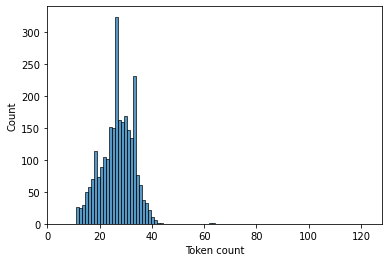

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 3
class_names = ['postive', 'negative', 'neutral']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 64])
torch.Size([32, 64])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 1.0333346310185223 accuracy 0.4744469870327994
Val   loss 0.9908114910125733 accuracy 0.5034246575342466

Epoch 2/30
----------
Train loss 0.854539996967083 accuracy 0.6300533943554539
Val   loss 0.8542483985424042 accuracy 0.6438356164383561

Epoch 3/30
----------
Train loss 0.6638909741872694 accuracy 0.7376048817696416
Val   loss 0.7888481378555298 accuracy 0.6541095890410958

Epoch 4/30
----------
Train loss 0.5257073731684103 accuracy 0.8085430968726164
Val   loss 0.8306450784206391 accuracy 0.6952054794520548

Epoch 5/30
----------
Train loss 0.3873628419710369 accuracy 0.8668954996186118
Val   loss 0.88673295378685 accuracy 0.7191780821917808

Epoch 6/30
----------
Train loss 0.28696828390040047 accuracy 0.9088482074752098
Val   loss 1.0677719116210938 accuracy 0.7020547945205479

Epoch 7/30
----------
Train loss 0.21007733092438885 accuracy 0.9393592677345538
Val   loss 1.0080858945846558 accuracy 0.7294520547945205

Epoch 8/30
----------
Train 

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
df_sem16test.Tweet[0]

'He who exalts himself shall      be humbled; and he who humbles himself shall be exalted.Matt 23:12.     #SemST'

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6677341873498799

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     postive       0.78      0.68      0.73       715
    negative       0.55      0.53      0.54       230
     neutral       0.56      0.74      0.64       304

    accuracy                           0.67      1249
   macro avg       0.63      0.65      0.63      1249
weighted avg       0.68      0.67      0.67      1249



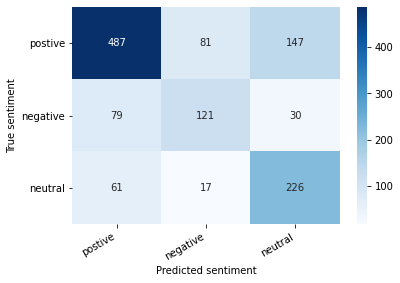

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.6677341873498799

In [ ]:
f1_score(y_test, y_pred, average='weighted') 

0.6703381891712437

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

## SemEval2020Task9

In [ ]:

%cd "/content/drive/MyDrive/TER BERTTweet/SemEval2020Task9"

/content/drive/MyDrive/TER BERTTweet/SemEval2020Task9


In [ ]:
!ls

best_model_state.bin			 train_14k_split_conll.txt
dev_3k_split_conll.txt			 TrainV1.tsv.txt
FinalTest.tsv.txt			 Ty.txt
Hindi_test_unalbelled_conll_updated.txt  ValidationV1.tsv.txt
test_labels_hinglish.txt


In [ ]:
 df_train = pd.read_csv("TrainV1.tsv.txt", sep="\t", header=None,  names=['id', 'body', 'target'])
df_val = pd.read_csv("ValidationV1.tsv.txt", sep="\t", header=None,  names=['id', 'body', 'target'])
df_test = pd.read_csv("FinalTest.tsv.txt", sep="\t", header=None,  names=['id', 'body'])
df_ytest = pd.read_csv("test_labels_hinglish.txt", sep=",", header=0, names=['id', 'sentiment'])

In [ ]:
df_train = df_val.append(df_train)

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
RANDOM_SEED = 16
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train['target'].unique()

array([1, 2, 0])

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

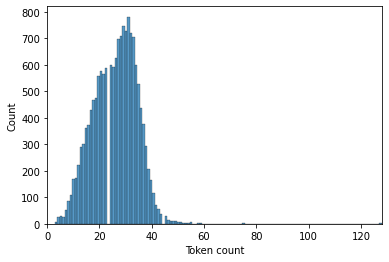

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 3
class_names = ['postive', 'neutral', 'negative']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.898730774479683 accuracy 0.5726122707147375
Val   loss 0.8179640661586415 accuracy 0.6051136363636364

Epoch 2/30
----------
Train loss 0.7857895989610691 accuracy 0.6504111321948135
Val   loss 0.7900246663527055 accuracy 0.6318181818181818

Epoch 3/30
----------
Train loss 0.7114520330019671 accuracy 0.6963946869070209
Val   loss 0.7997756378217177 accuracy 0.6505681818181818

Epoch 4/30
----------
Train loss 0.6382512974618662 accuracy 0.7387729285262492
Val   loss 0.7896846131844955 accuracy 0.6744318181818182

Epoch 5/30
----------
Train loss 0.5699685186448723 accuracy 0.7724225173940544
Val   loss 0.8422589296644384 accuracy 0.6693181818181818

Epoch 6/30
----------
Train loss 0.5085943742833956 accuracy 0.8049335863377609
Val   loss 0.9030815005302429 accuracy 0.6721590909090909

Epoch 7/30
----------
Train loss 0.453523014952438 accuracy 0.8316888045540798
Val   loss 0.9593692096796903 accuracy 0.66875

Epoch 8/30
----------
Train loss 0.40324

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else: 
    return 2

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6553333333333333

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

## SemEval 2019 task 6


In [ ]:
%cd /content/drive/MyDrive/TER BERTTweet/SemEval2019Task6

/content/drive/MyDrive/TER BERTTweet/SemEval2019Task6


In [ ]:
!ls

best_model_state.bin  log_bert		      Roberta_best_model_state.bin
labels-levela.csv     log_roberta	      testset-levela.tsv
labels-levelb.csv     olid-annotation.txt     testset-levelb.tsv
labels-levelc.csv     olid-training-v1.0.tsv  testset-levelc.tsv
log		      README.txt


In [ ]:
df_train = pd.read_csv("olid-training-v1.0.tsv", sep="\t", header=0,  names=['id', 'body', 'target', 'dropme', 'dropme2'])
df_test = pd.read_csv("testset-levela.tsv", sep="\t", header=0,  names=['id', 'body'])
df_ytest = pd.read_csv("labels-levela.csv", sep=",", header=0, names=['id', 'sentiment'])

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
df_train

,id,body,target,dropme,dropme2
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [ ]:
df_test

,id,body,sentiment
0,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
1,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
2,13876,#Watching #Boomer getting the news that she is...,NOT
3,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF
4,83681,. . . What the fuck did he do this time?,OFF
...,...,...,...
854,73439,#DespicableDems lie again about rifles. Dem Di...,OFF
855,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT
856,67018,3 people just unfollowed me for talking about ...,OFF
857,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT


In [ ]:
df_train['target'].unique()

array(['OFF', 'NOT'], dtype=object)

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'OFF':
    return 0
  elif sentiment == 'NOT':
    return 1

In [ ]:
df_train['target'] = df_train.target.apply(sentiment_encode)

In [ ]:
RANDOM_SEED = 22
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


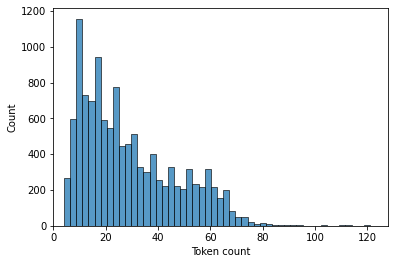

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['offensive', 'not_offensive']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 121])
torch.Size([32, 121])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.4950646757280539 accuracy 0.7654414232964082
Val   loss 0.4218552651859465 accuracy 0.8066465256797583

Epoch 2/30
----------
Train loss 0.3912653756445279 accuracy 0.831067472306143
Val   loss 0.4341502008693559 accuracy 0.7960725075528701

Epoch 3/30
----------
Train loss 0.3367893061433337 accuracy 0.8600201409869084
Val   loss 0.4648965221075785 accuracy 0.7953172205438066

Epoch 4/30
----------
Train loss 0.2763696735170508 accuracy 0.893168848606915
Val   loss 0.5153726594788688 accuracy 0.7960725075528701

Epoch 5/30
----------
Train loss 0.21876580896350398 accuracy 0.9220375965088956
Val   loss 0.5650750969847044 accuracy 0.802870090634441

Epoch 6/30
----------
Train loss 0.1789422093243925 accuracy 0.9384860691507217
Val   loss 0.6191182150727227 accuracy 0.790785498489426

CPU times: user 13min 28s, sys: 11min 48s, total: 25min 17s
Wall time: 25min 26s


In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8451688009313154

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

    offensive       0.75      0.67      0.71       239
not_offensive       0.88      0.91      0.90       620

     accuracy                           0.85       859
    macro avg       0.81      0.79      0.80       859
 weighted avg       0.84      0.85      0.84       859



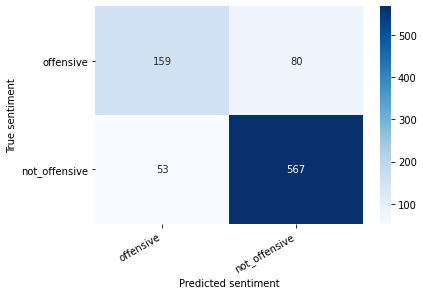

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.8451688009313155

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.8421839046315193

##SemEval 2020 Task 12

In [ ]:
%cd /content/drive/MyDrive/TER BERTTweet/SemEval2020Task12

In [ ]:
!ls

task_a_distant.tsv	test_b_labels_all.csv	test_c_labels.csv
test_a_labels_all.csv	test_b_labels.csv	test_c_labels_easy.csv
test_a_labels.csv	test_b_labels_easy.csv	test_c_labels_hard.csv
test_a_labels_easy.csv	test_b_labels_hard.csv	test_c_tweets_all.tsv
test_a_labels_hard.csv	test_b_tweets_all.tsv	test_c_tweets.tsv
test_a_tweets_all.tsv	test_b_tweets.tsv
test_a_tweets.tsv	test_c_labels_all.csv


In [ ]:
df_train = pd.read_csv("task_a_distant.tsv", sep="\t", header=0,  names=['id', 'body', 'target'])
df_test = pd.read_csv("test_a_tweets_all.tsv", sep="\t", header=0,  names=['id', 'body'])
df_ytest = pd.read_csv("test_a_labels_all.csv", sep=",", header=0, names=['id', 'sentiment'])

NameError: ignored

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
df_train['target'].unique()

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'OFF':
    return 0
  elif sentiment == 'NOT':
    return 1

In [ ]:
df_train['target'] = df_train.target.apply(sentiment_encode)

In [ ]:
RANDOM_SEED = 16
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
data = next(iter(val_data_loader))
data.keys()

In [ ]:
n_classes = 2
class_names = ['offensive', 'not_offensive']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

NameError: ignored

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

NameError: ignored

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

NameError: ignored

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred, average='weighted')